## MODELLING

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix


df = pd.read_csv('bank_marketing_cleaned.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contacted_before,pdays_clean,previous_capped,campaign_winsorized
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1


### Preprocessing: Encode & Impute Features

In [20]:
df.columns


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'contacted_before', 'pdays_clean',
       'previous_capped', 'campaign_winsorized'],
      dtype='object')

In [21]:
columns =[ 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'contacted_before', 'pdays_clean',
       'previous_capped', 'campaign_winsorized']
for col in columns:
    print(col, df[col].unique())

age [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' nan 'entrepreneur' 'student']
marital ['married' 'single' 'divorced' nan]
education ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course' nan
 'university.degree' 'illiterate']
default ['no' nan 'yes']
housing ['no' 'yes' nan]
loan ['no' 'yes' nan]
contact ['telephone' 'cellular']
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week ['mon' 'tue' 'wed' 'thu' 'fri']
campaign [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]
pdays [999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18 

In [22]:
X = df.drop(columns=['y'])
y = df['y']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_cols),
    ('num', numeric_pipeline, numeric_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

### Baseline: Dummy Classifier

In [23]:
dummy_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_test)

print("Dummy Classifier Performance:")
print(confusion_matrix(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy))

Dummy Classifier Performance:
[[10961     0]
 [ 1392     0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10961
           1       0.00      0.00      0.00      1392

    accuracy                           0.89     12353
   macro avg       0.44      0.50      0.47     12353
weighted avg       0.79      0.89      0.83     12353



C:\Users\abdin\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdin\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdin\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Base Model: Logistic Regression

In [24]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)

print("Logistic Regression Performance:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Performance:
[[10823   138]
 [ 1101   291]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10961
           1       0.68      0.21      0.32      1392

    accuracy                           0.90     12353
   macro avg       0.79      0.60      0.63     12353
weighted avg       0.88      0.90      0.88     12353



### Conclusion

- The **Dummy Classifier** always predicts the majority class, giving a baseline for comparison.
- The **Logistic Regression** model shows significantly better performance and is interpretable, making it suitable for business environments.
- This notebook establishes a strong foundation for comparing ensemble and boosting models next.


### Main models

In [28]:
#lets do a comparison of dummy,baseline and main models accuracies
# Split features and target
X = df.drop(columns=['y'])
y = df['y']

# Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipelines for preprocessing
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_cols),
    ('num', numeric_pipeline, numeric_cols)
])

# Define models
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression (Baseline)': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': BernoulliNB(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate each model
print("Model Performance (10-Fold Cross-Validation):\n")
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    score = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    print(f"{name:<30} Accuracy: {score.mean() * 100:.2f}%")

Model Performance (10-Fold Cross-Validation):

Dummy Classifier               Accuracy: 88.73%
Logistic Regression (Baseline) Accuracy: 90.02%
Decision Tree                  Accuracy: 84.13%
Naive Bayes                    Accuracy: 80.28%
Random Forest                  Accuracy: 89.21%
Gradient Boosting              Accuracy: 90.03%


Gradient Boosting achieved the highest accuracy (90.03%), closely followed by Logistic Regression, showing strong performance.

The Dummy Classifier serves as a baseline; all other models outperform it, indicating the models are learning meaningful patterns.

While Random Forest performs well, it's slightly below the baseline Logistic Regression in this case.

Naive Bayes and Decision Tree showed lower accuracy, suggesting they may not generalize well for this dataset.

In [27]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
[[10648   313]
 [ 1014   378]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10961
           1       0.55      0.27      0.36      1392

    accuracy                           0.89     12353
   macro avg       0.73      0.62      0.65     12353
weighted avg       0.87      0.89      0.88     12353



In [29]:
# Define the pipeline
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Fit the model
gb_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_gb = gb_pipeline.predict(X_test)

# Evaluation
print("Gradient Boosting Performance:")
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Performance:
[[10797   164]
 [ 1064   328]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10961
           1       0.67      0.24      0.35      1392

    accuracy                           0.90     12353
   macro avg       0.79      0.61      0.65     12353
weighted avg       0.88      0.90      0.88     12353



Random Forest

Accuracy: 89%

F1-score (class 1): 0.36

Performs well overall, but struggles to recall class 1 (only 27%).

Gradient Boosting

Accuracy: 90%

F1-score (class 1): 0.35

Slightly better accuracy and precision on class 1, but still low recall (24%).

Both models are strong on the majority class but have limited recall for minority class (1) — important if predicting this class is critical.

### HYPER PARAMETER TUNING

Perfoming RandomizedSearchCV to tune both random classifier model and gradient boosting model


In [32]:

# Random Forest parameter grid
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Randomized search
rf_search = RandomizedSearchCV(
    rf_pipeline, rf_param_grid, n_iter=10, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1
)

# Fit the model
rf_search.fit(X_train, y_train)

# Evaluate
print("Best Random Forest Performance:")
y_pred_rf = rf_search.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Best RF Params:", rf_search.best_params_)


Best Random Forest Performance:
[[10814   147]
 [ 1083   309]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10961
           1       0.68      0.22      0.33      1392

    accuracy                           0.90     12353
   macro avg       0.79      0.60      0.64     12353
weighted avg       0.88      0.90      0.88     12353

Best RF Params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10}


In [33]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting parameter grid
gb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0]
}

# Pipeline
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Randomized search
gb_search = RandomizedSearchCV(
    gb_pipeline, gb_param_grid, n_iter=10, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1
)

# Fit the model
gb_search.fit(X_train, y_train)

# Evaluate
print("Best Gradient Boosting Performance:")
y_pred_gb = gb_search.predict(X_test)
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))
print("Best GB Params:", gb_search.best_params_)


Best Gradient Boosting Performance:
[[10801   160]
 [ 1068   324]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10961
           1       0.67      0.23      0.35      1392

    accuracy                           0.90     12353
   macro avg       0.79      0.61      0.65     12353
weighted avg       0.88      0.90      0.88     12353

Best GB Params: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}


In [34]:
final_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42
    ))
])

final_rf.fit(X_train, y_train)
y_final_pred_rf = final_rf.predict(X_test)

print("Final Tuned Random Forest Performance:")
print(confusion_matrix(y_test, y_final_pred_rf))
print(classification_report(y_test, y_final_pred_rf))


Final Tuned Random Forest Performance:
[[10814   147]
 [ 1083   309]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10961
           1       0.68      0.22      0.33      1392

    accuracy                           0.90     12353
   macro avg       0.79      0.60      0.64     12353
weighted avg       0.88      0.90      0.88     12353



In [35]:
from sklearn.ensemble import GradientBoostingClassifier

# Final Gradient Boosting Pipeline
final_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    ))
])

# Fit and predict
final_gb.fit(X_train, y_train)
y_final_pred_gb = final_gb.predict(X_test)

# Evaluation
print("Final Tuned Gradient Boosting Performance:")
print(confusion_matrix(y_test, y_final_pred_gb))
print(classification_report(y_test, y_final_pred_gb))


Final Tuned Gradient Boosting Performance:
[[10801   160]
 [ 1068   324]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10961
           1       0.67      0.23      0.35      1392

    accuracy                           0.90     12353
   macro avg       0.79      0.61      0.65     12353
weighted avg       0.88      0.90      0.88     12353



Tuned Random Forest

Accuracy: 90%

F1-score (class 1): 0.33

Improved overall accuracy, but still low recall (22%) on minority class.

Tuned Gradient Boosting

Accuracy: 90%

F1-score (class 1): 0.35

Slight improvement on minority class recall (23%), but still limited.

Despite tuning, both models favor the majority class, with class 1 recall remaining a challenge. Consider resampling techniques if class 1 prediction is critical.

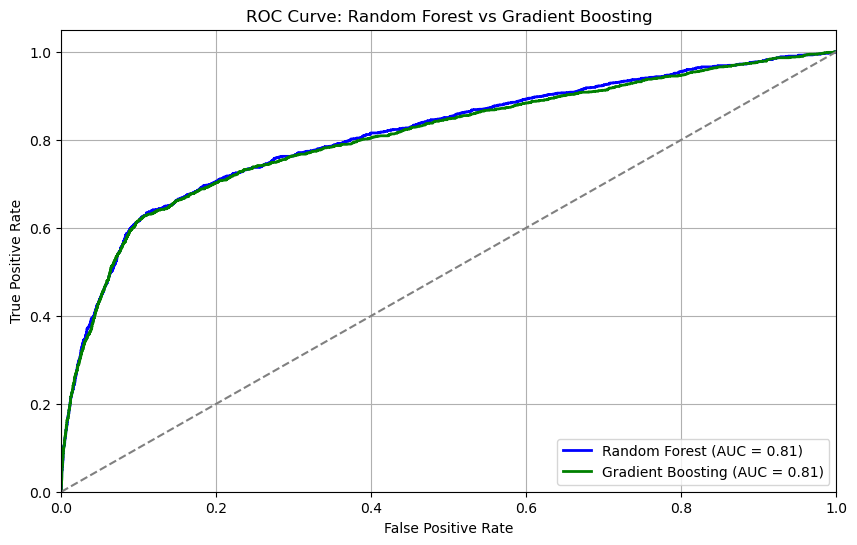

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_proba_rf = rf_search.best_estimator_.predict_proba(X_test)[:, 1]
y_proba_gb = gb_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_gb, tpr_gb, color='green', lw=2, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_gb)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest vs Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Both models show solid predictive power, with identical AUC (Area Under the Curve) scores of 0.81, meaning they’re equally effective at distinguishing between classes.


### Feature Importance

In [37]:
rf_model = rf_search.best_estimator_.named_steps['classifier']
gb_model = gb_search.best_estimator_.named_steps['classifier']


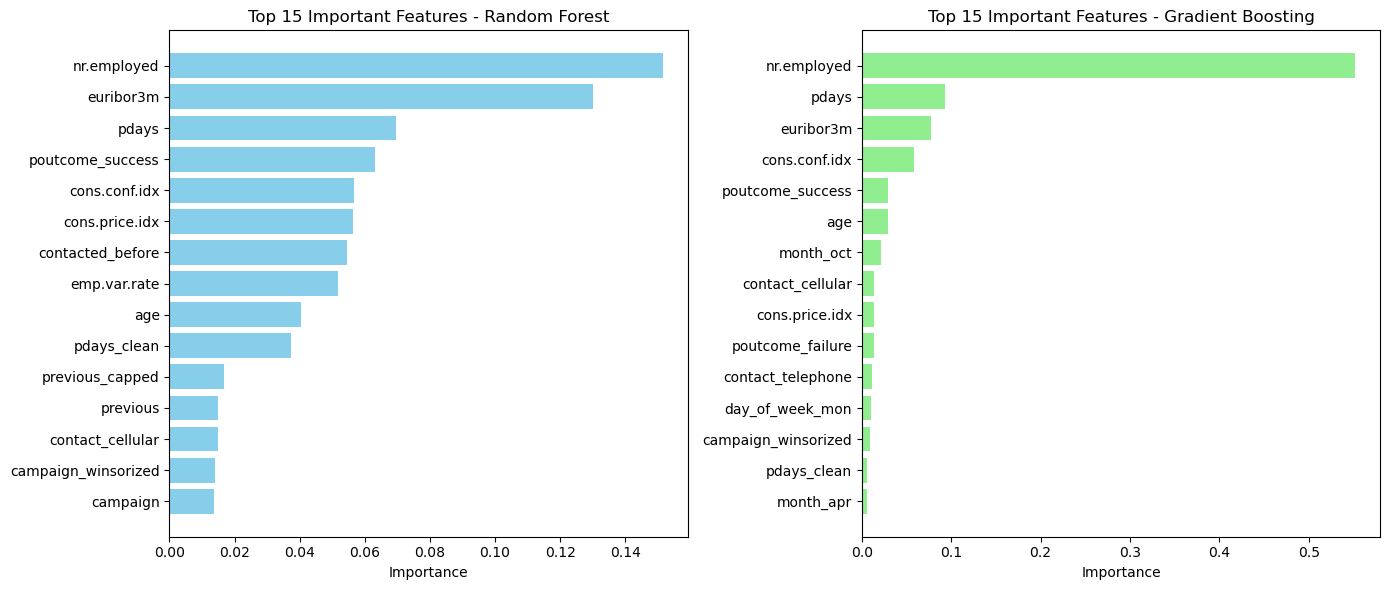

In [40]:
# 1. Get feature names after preprocessing
onehot_columns = rf_search.best_estimator_.named_steps['preprocessor']\
    .named_transformers_['cat'].named_steps['encoder']\
    .get_feature_names_out(categorical_cols)

feature_names = np.concatenate([onehot_columns, numeric_cols])

# 2. Extract importances
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

# 3. Create DataFrames
rf_feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

gb_feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_importances
}).sort_values(by='Importance', ascending=False)

# 4. Plot top 15
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(rf_feat_imp_df['Feature'][:15][::-1], rf_feat_imp_df['Importance'][:15][::-1], color='skyblue')
plt.title("Top 15 Important Features - Random Forest")
plt.xlabel("Importance")

plt.subplot(1, 2, 2)
plt.barh(gb_feat_imp_df['Feature'][:15][::-1], gb_feat_imp_df['Importance'][:15][::-1], color='lightgreen')
plt.title("Top 15 Important Features - Gradient Boosting")
plt.xlabel("Importance")

plt.tight_layout()
plt.show()

Common Top Features Across Both Models:
- nr.employed, euribor3m, and pdays are consistently high-ranking, signaling strong predictive power tied to employment and interest rate indicators.
- poutcome_success suggests past campaign success has strong influence.
- cons.conf.idx and cons.price.idx reflect consumer sentiment and economic outlook.
Notable Differences:
- Gradient Boosting prioritizes features like month_oct, poutcome_failure, and contact_telephone, which don’t rank as high in Random Forest. This hints at nuanced interactions with campaign timing and contact methods.
- Random Forest gives more weight to engineered variables like contacted_before, pdays_clean, and campaign, possibly showing broader patterns picked up through bootstrapping.

🎯 Actionable Recommendation
For ABC Bank presentation:
- Emphasize shared top features for consistency across models—they validate their predictive strength.
- Highlight unique features in each model to justify why multiple approaches can reveal complementary insights.
- Consider feature engineering opportunities around campaign timing and contact strategy to further boost prediction accuracy.

